<a href="https://colab.research.google.com/github/ayush-sys/twitter-sentiment-analysis/blob/main/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Twitter Sentiment Analysis


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d kazanova/sentiment140

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip \*.zip && rm \*.zip

Archive:  sentiment140.zip
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: training.1600000.processed.noemoticon.csv  
rm: cannot remove '*.zip': No such file or directory


In [ ]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

**Reading Dataset**

In [ ]:
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head(10)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


**Data Analysis**

In [ ]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [ ]:
print('length of data is', len(df))

length of data is 1600000


In [ ]:
df.shape

(1600000, 6)

In [ ]:
df.info

<bound method DataFrame.info of          target  ...                                               text
0             0  ...  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1             0  ...  is upset that he can't update his Facebook by ...
2             0  ...  @Kenichan I dived many times for the ball. Man...
3             0  ...    my whole body feels itchy and like its on fire 
4             0  ...  @nationwideclass no, it's not behaving at all....
...         ...  ...                                                ...
1599995       4  ...  Just woke up. Having no school is the best fee...
1599996       4  ...  TheWDB.com - Very cool to hear old Walt interv...
1599997       4  ...  Are you ready for your MoJo Makeover? Ask me f...
1599998       4  ...  Happy 38th Birthday to my boo of alll time!!! ...
1599999       4  ...  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 6 columns]>

In [ ]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [ ]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   6
Count of rows in the data is:   1600000


In [ ]:
df['target'].unique()

array([0, 4])

In [ ]:
df['target'].nunique()

2

**Data Visualization**

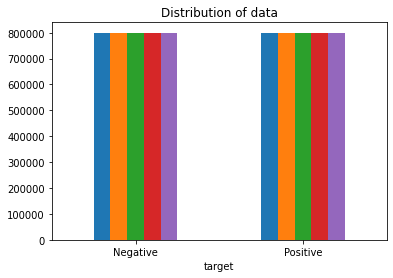

In [ ]:
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
text, sentiment = list(df['text']), list(df['target'])

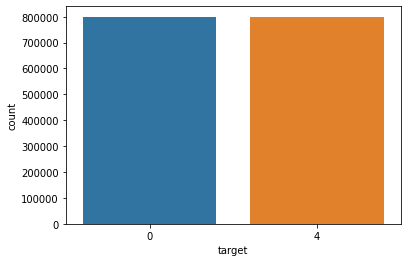

In [ ]:
sns.countplot(x='target', data=df)

**Data Preprocessing**

In [ ]:
data=df[['text','target']]
data['target'] = data['target'].replace(4,1)
data['target'].unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


array([0, 1])

In [ ]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [ ]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [ ]:
dataset = pd.concat([data_pos, data_neg])

In [ ]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

19995    not much time off this weekend, work trip to m...
19996                            one more day of holidays 
19997    feeling so down right now .. i hate you damn h...
19998    geez,i hv to read the whole book of personalit...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

**Defining Stopwords**

In [ ]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

**Cleaning Data**

In [ ]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

19995    not much time off this weekend work trip to ma...
19996                            one more day of holidays 
19997    feeling so down right now  i hate you damn hum...
19998    geezi hv to read the whole book of personality...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [ ]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

19995    not much time off this weekend work trip to ma...
19996                            one more day of holidays 
19997    feeling so down right now  i hate you damn hum...
19998    geezi hv to read the whole book of personality...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [ ]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

19995    not much time off this weekend work trip to ma...
19996                            one more day of holidays 
19997    feeling so down right now  i hate you damn hum...
19998    geezi hv to read the whole book of personality...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

In [ ]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

19995    not much time off this weekend work trip to ma...
19996                            one more day of holidays 
19997    feeling so down right now  i hate you damn hum...
19998    geezi hv to read the whole book of personality...
19999    i threw my sign at donnie and he bent over to ...
Name: text, dtype: object

**Tokenziation of text**

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000              []
800001          [w, w]
800002    [w, w, w, w]
800003             [w]
800004              []
Name: text, dtype: object

In [ ]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000              []
800001          [w, w]
800002    [w, w, w, w]
800003             [w]
800004              []
Name: text, dtype: object

In [ ]:
X=data.text
y=data.target

**Negative word cloud**

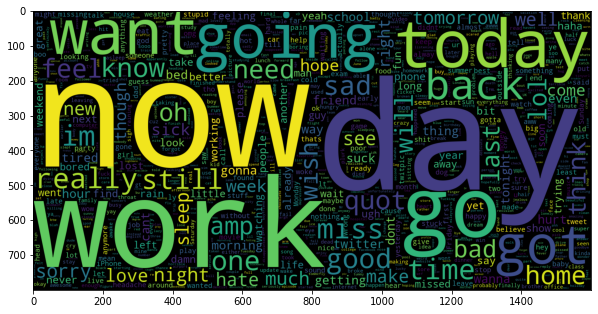

In [ ]:
data_neg = data['text'][:800000]
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

**Positive word cloud**

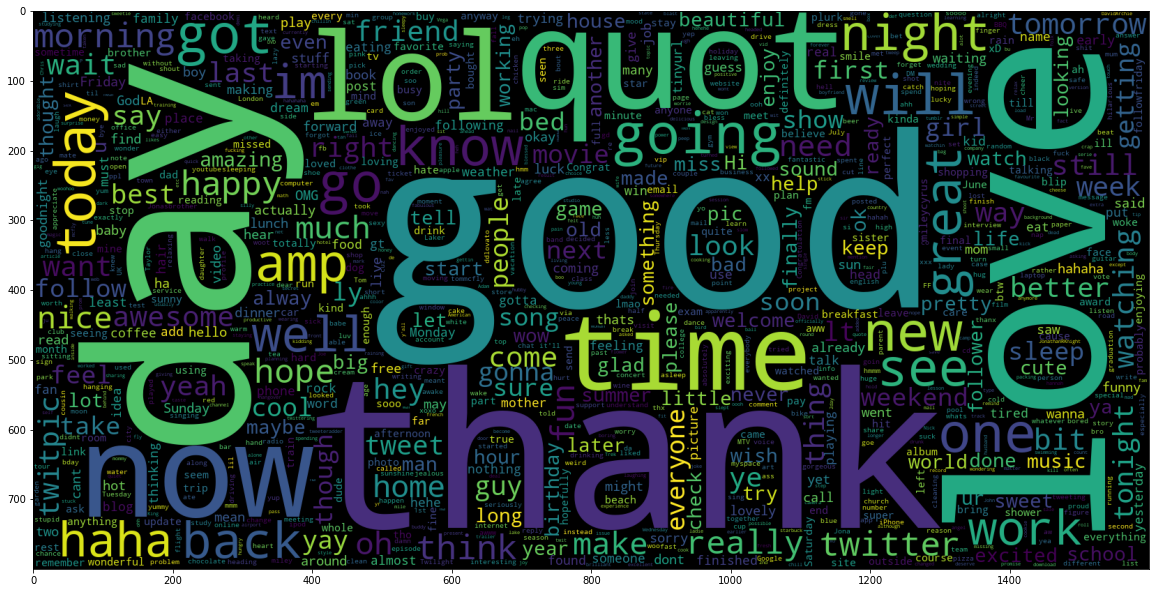

In [ ]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (10,10))
plt.imshow(wc)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.15, random_state =12345)

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  500000


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

**Model Evalaution**

In [ ]:
def model_Evaluate(model):
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)


              precision    recall  f1-score   support

           0       0.80      0.79      0.80    119793
           1       0.80      0.81      0.80    120207

    accuracy                           0.80    240000
   macro avg       0.80      0.80      0.80    240000
weighted avg       0.80      0.80      0.80    240000



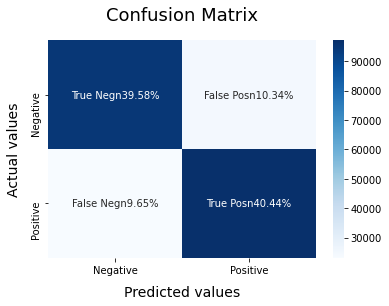

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
sc = accuracy_score(y_pred1,y_test)
print(f'Accuracy Score in Naive Byes {sc}')

Accuracy Score in Naive Byes 0.8001708333333334


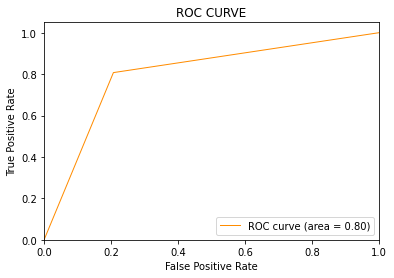

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.82      0.82    119793
           1       0.82      0.83      0.83    120207

    accuracy                           0.83    240000
   macro avg       0.83      0.83      0.83    240000
weighted avg       0.83      0.83      0.83    240000



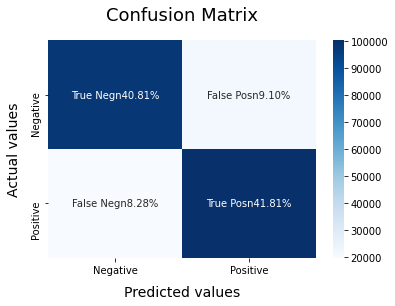

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred2 = LRmodel.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
sc2 = accuracy_score(y_pred2,y_test)
print(f'Accuracy Score in Logistic Regression {sc2}')

Accuracy Score in Naive Byes 0.8262541666666666


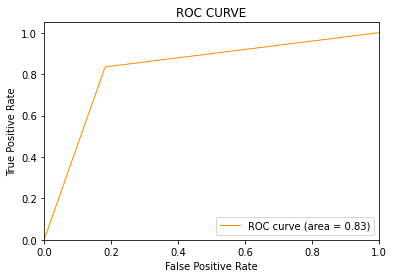

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.81      0.81    119793
           1       0.81      0.82      0.82    120207

    accuracy                           0.82    240000
   macro avg       0.82      0.82      0.82    240000
weighted avg       0.82      0.82      0.82    240000



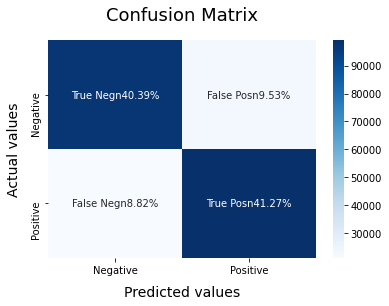

In [ ]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred3 = SVCmodel.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
sc3 = accuracy_score(y_pred3,y_test)
print(f'Accuracy Score in Logistic Regression {sc3}')

Accuracy Score in Logistic Regression 0.81655


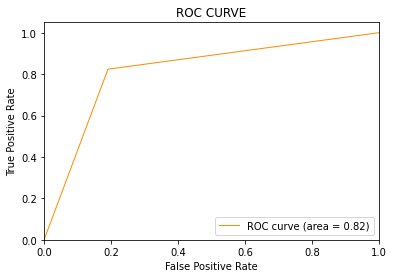

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

**Conclusion**

*   Accuracy: NaiveByes < SVM < Logistic Regression


